In [54]:
from __future__ import print_function
import time
import numpy as np

#from scipy.cluster import vq
from sklearn.cluster import k_means
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imread, imsave

np.random.seed(0)


from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19

In [55]:
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
from io import BytesIO

In [56]:
def display_image(a, fmt='jpeg'):
    a = np.uint8(np.clip(a/255., 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [57]:
style_img_path = "Monet/style.png"
style_mask_path = "Monet/style_mask.png"
target_mask_path = "Monet/target_mask.png"

content_img_path = None
target_img_prefix = "generated/monet_"
use_content_img = content_img_path is not None

nb_labels = 4
nb_colors = 3 # RGB

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


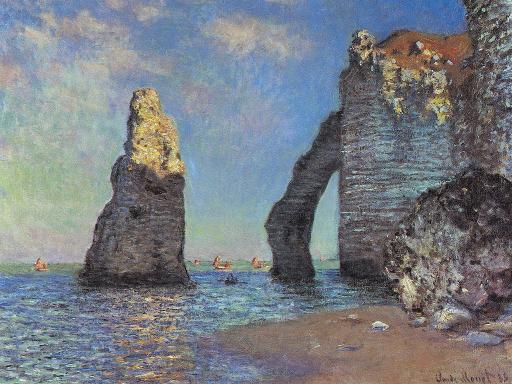

In [58]:
style_img  = imread(style_img_path, mode='RGB')
display_image(style_img)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


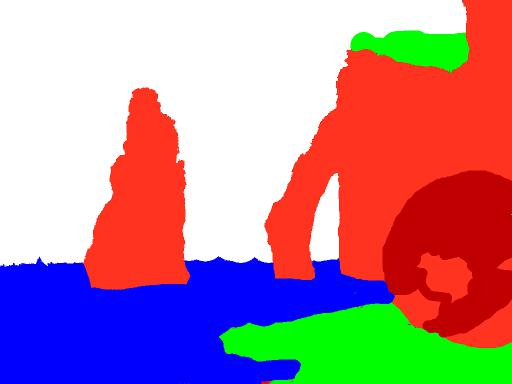

In [59]:
style_mask_img = imread(style_mask_path)
display_image(style_mask_img)

384 512


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


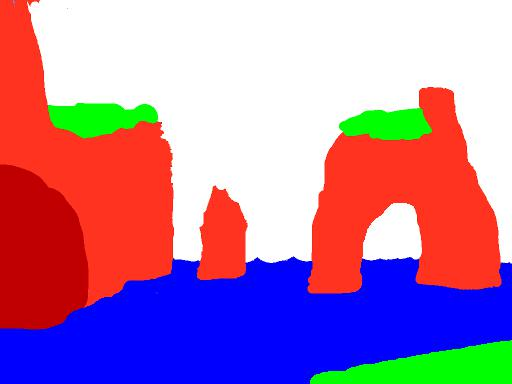

In [60]:
# determine image sizes based on target_mask

ref_img = imread(target_mask_path)

img_nrows, img_ncols = ref_img.shape[:2]
print(img_nrows,img_ncols)
display_image(ref_img)

In [61]:
total_variation_weight = 5000.
style_weight = 1.
content_weight = 0.025 if use_content_img else 0

content_feature_layers = ['block4_conv2']
style_feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']


In [62]:
# helper functions for reading/processing images

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [63]:
def deprocess_image(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    
    x = x[:, :, ::-1]
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [64]:
def load_semantic_map():
    target_mask_img = img_to_array(load_img(target_mask_path,target_size=(img_nrows, img_ncols)))
    style_mask_img = img_to_array(load_img(style_mask_path,target_size=(img_nrows, img_ncols)))

    if K.image_data_format() == 'th':
        mask_vecs = np.vstack([style_mask_img.reshape((3, -1)).T, target_mask_img.reshape((3, -1)).T])
    else:
        mask_vecs = np.vstack([style_mask_img.reshape((-1, 3)), target_mask_img.reshape((-1, 3))])

    #_, labels = vq.kmeans2(mask_vecs, nb_labels, missing='raise')
    _, labels, _ = k_means(mask_vecs.astype("float64"), nb_labels)
    
    style_mask_label = labels[:img_nrows*img_ncols].reshape((img_nrows, img_ncols))
    target_mask_label = labels[img_nrows*img_ncols:].reshape((img_nrows, img_ncols))
    style_mask = np.stack([style_mask_label==r for r in range(nb_labels)], axis = 0)
    target_mask = np.stack([target_mask_label==r for r in range(nb_labels)], axis = 0)
    return np.expand_dims(style_mask, axis=0), np.expand_dims(target_mask, axis=0)

In [65]:
# create tensor variables for images

if K.image_data_format() == 'th':
    shape = (1, nb_colors, img_nrows, img_ncols)
else:
    shape = (1, img_nrows, img_ncols, nb_colors)    

style_image = K.variable(preprocess_image(style_img_path))
target_image = K.placeholder(shape = shape)

if use_content_img:
    content_image = K.variable(preprocess_image(content_img_path))
else:
    content_image = K.zeros(shape = shape)

images = K.concatenate([style_image, target_image, content_image], axis=0)

In [66]:
# create tensor variables for masks

raw_style_mask, raw_target_mask = load_semantic_map()
style_mask = K.variable(raw_style_mask.astype("float32"))
target_mask = K.variable(raw_target_mask.astype("float32"))
masks = K.concatenate([style_mask, target_mask], axis=0)

# index constants for images and tasks variables

STYLE, TARGET, CONTENT = 0, 1, 2

In [67]:
# build image model, mask model and target
# vgg19 for image model
image_model = vgg19.VGG19(include_top=False, input_tensor=images)

In [68]:
# pooling layers for mask model
mask_input = Input(tensor=masks, shape=(None, None, None), name="mask_input")
x = mask_input

In [69]:
#from keras import backend as K
#K.set_image_dim_ordering('th')

for layer in image_model.layers[1:]:
    name = 'mask_%s' % layer.name
    print(layer.name)
    if 'conv' in layer.name:
        x = AveragePooling2D((3, 3), strides = (1, 1), name=name, padding="same",data_format="channels_first")(x)
        #x = MaxPooling2D((3, 3), strides = (1, 1), name=name, border_mode="same", )(x)
    elif 'pool' in layer.name:
        #x = MaxPooling2D((2, 2), name=name)(x)
        x = AveragePooling2D((2, 2), name=name,data_format="channels_first")(x)



block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [70]:
mask_model = Model(mask_input, x)

# collect features from image_model and task_model
image_features = {}
mask_features = {}

for img_layer, mask_layer in zip(image_model.layers, mask_model.layers):
    if 'conv' in img_layer.name:
        assert 'mask_' + img_layer.name == mask_layer.name
        layer_name = img_layer.name
        img_feat, mask_feat = img_layer.output, mask_layer.output
        image_features[layer_name] = img_feat
        mask_features[layer_name] = mask_feat

In [71]:
# define loss functions
# gram matrix helper function

def gram_matrix(x):
    assert 3 == K.ndim(x)
    feats = K.batch_flatten(x)
    gram = K.dot(feats, K.transpose(feats))
    return gram



In [72]:
# style loss in one region

def region_style_loss(style_image, target_image, style_mask, target_mask):
    assert 3 == K.ndim(style_image) == K.ndim(target_image)
    assert 2 == K.ndim(style_mask) == K.ndim(target_mask)
    s = gram_matrix(style_image * style_mask) * K.sum(style_mask)
    c = gram_matrix(target_image * target_mask) * K.sum(target_mask)
    return K.sum(K.square(s - c)) 

In [73]:
# style loss between style and target images, with
# regions defined in a set of masks

def style_loss(style_image, target_image, style_masks, target_masks):
    assert 3 == K.ndim(style_image) == K.ndim(target_image)
    assert 3 == K.ndim(style_masks) == K.ndim(target_masks)
    loss = K.variable(0)
    for i in range(nb_labels):
        style_mask = style_masks[i, :, :]
        target_mask = target_masks[i, :, :]
        loss.assign_add(region_style_loss(style_image, target_image, style_mask, target_mask))
    size = img_nrows * img_ncols
    return loss / (4. * nb_colors**2 * size**2)



In [74]:
# content loss between content and target images

def content_loss(content_image, target_image):
    return K.sum(K.square(target_image - content_image))



In [75]:
# total variance loss for an image

def total_variation_loss(x):
    assert 4 == K.ndim(x)
    if K.image_data_format() == 'th':
        a = K.square(x[:, :, :img_nrows-1, :img_ncols-1] - x[:, :, 1:, :img_ncols-1])
        b = K.square(x[:, :, :img_nrows-1, :img_ncols-1] - x[:, :, :img_nrows-1, 1:])
    else:
        a = K.square(x[:, :img_nrows-1, :img_ncols-1, :] - x[:, 1:, :img_ncols-1, :])
        b = K.square(x[:, :img_nrows-1, :img_ncols-1, :] - x[:, :img_nrows-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [76]:
loss = K.variable(0)
for layer in content_feature_layers:
    content_feat = image_features[layer][CONTENT, :, :, :]
    target_feat = image_features[layer][TARGET, :, :, :]
    loss.assign_add(content_weight * content_loss(content_feat, target_feat))


In [77]:
for layer in style_feature_layers:
    style_feat = image_features[layer][STYLE, :, :, :]
    style_feat=K.permute_dimensions(style_feat,[2,0,1])
    
    target_feat = image_features[layer][TARGET, :, :, :]
    target_feat=K.permute_dimensions(target_feat,[2,0,1])
    
    style_masks = mask_features[layer][STYLE, :, :, :]
    target_masks = mask_features[layer][TARGET, :, :, :]
    
    sl = style_loss(style_feat, target_feat, style_masks, target_masks)
    loss.assign_add((style_weight / len(style_feature_layers)) * sl)


In [78]:
loss.assign_add(total_variation_weight * total_variation_loss(target_image))
loss_grads = K.gradients(loss, target_image)

In [79]:
# Evaluator class for computing efficiency

outputs = [loss]
if type(loss_grads) in {list, tuple}:
    outputs += loss_grads
else:
    outputs.append(loss_grads)

In [80]:
f_outputs = K.function([target_image], outputs)

In [81]:
def eval_loss_and_grads(x):

    if K.image_data_format() == 'th':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))

    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:

        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


In [82]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None



    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value



    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values



In [83]:
evaluator = Evaluator()
# Generate images by iterative optimization

if K.image_data_format() == 'th':
    x = np.random.uniform(0, 255, (1, 3, img_nrows, img_ncols)) - 128.
else:
    x = np.random.uniform(0, 255, (1, img_nrows, img_ncols, 3)) - 128.



In [84]:
for i in range(30):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grads, maxfun=20)

    # save current generated image
    img = deprocess_image(x.copy())
    fname = target_img_prefix + '_at_iteration_%d.png' % i
    clear_output()
    print('Current loss value:', min_val)
    display_image(img)
    imsave(fname, img)

    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0


AttributeError: 'NoneType' object has no attribute 'name'